#Pneumonia dataset

1. IMPORTING THE LIBRARIES

In [ ]:
import os # reading the  files

import numpy as np

import cv2
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
import keras,os
from keras.preprocessing.image import ImageDataGenerator # keras preprocessor
import numpy as np

from keras.models import Sequential # sequential model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten # layers we will use in the sequential model
from keras import optimizers
from keras.optimizers import Adam # model optimizer

from keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks

import matplotlib.pyplot as plt # drawing plots while training and testing

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt

from keras.layers import Activation, Flatten,  Dropout
from keras.layers import BatchNormalization 

from sklearn.metrics import precision_recall_curve


 2. EXPLORING THE DATASET

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data came presplit into test, training , and validation dataset
Location of the directories already loaded in google drive

The source of the dataset is https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.
The data was pre divided into training,testing and validation.

In [ ]:
train_dir = '/content/drive/MyDrive/pneumonia/chest_xray/test'

valid_dir = '/content/drive/MyDrive/pneumonia/chest_xray/train'

test_dir = '/content/drive/MyDrive/pneumonia/chest_xray/val'

Reading the files within the test, train, and val folders

In [ ]:
train_normal = os.path.join(train_dir, 'NORMAL')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')

valid_normal = os.path.join(valid_dir, 'NORMAL')
valid_pneumonia = os.path.join(valid_dir, "PNEUMONIA")

test_normal = os.path.join(test_dir, "NORMAL")
test_pneumonia = os.path.join(test_dir, 'PNEUMONIA')

In [ ]:
print('Total normal training x-ray images:', (len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))))
print('Total validation x-ray images:', (len(os.listdir(valid_normal)) + len(os.listdir(valid_pneumonia))))
print('Total testing x-ray images:', (len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))))

Total normal training x-ray images: 624
Total validation x-ray images: 5218
Total testing x-ray images: 18


LOOKING AT THE NORMAL CHEST X RAY IMAGE

Text(0.5, 1.0, 'Normal Patient X RAY')

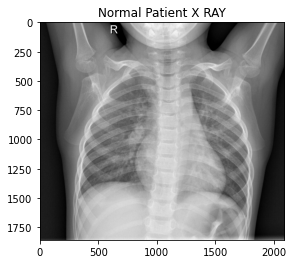

In [ ]:
normal_img =  cv2.imread('/content/drive/MyDrive/pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(normal_img)
plt.title('Normal Patient X RAY')

LOOKING AT THE PNEUMONIA CHEST X RAY IMAGES

Text(0.5, 1.0, 'Pneumonia Patient X RAY')

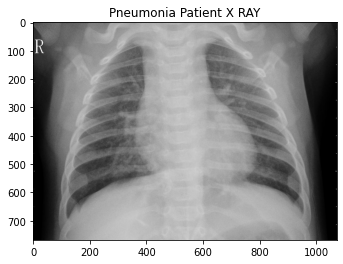

In [ ]:
pneumonia_img =  cv2.imread('/content/drive/MyDrive/pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
plt.imshow(pneumonia_img)
plt.title('Pneumonia Patient X RAY')

x ray of pneumonia patient


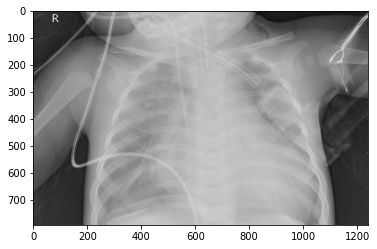

In [ ]:
pneu_img = cv2.imread('/content/drive/MyDrive/pneumonia/chest_xray/train/PNEUMONIA/person1008_bacteria_2939.jpeg')
plt.imshow(pneu_img)
print('x ray of pneumonia patient')

Computers, learn/see in not such a different way from us. They will, however, need to look and analyze thousands upon thousands of images before they can generalize and say that a yellow umbrella falls under the same category as a black umbrella. This is because what they see are not pictures, but numerical representaions of pixels describing these pictures. So while we see 'things in pictures, a computer sees this:

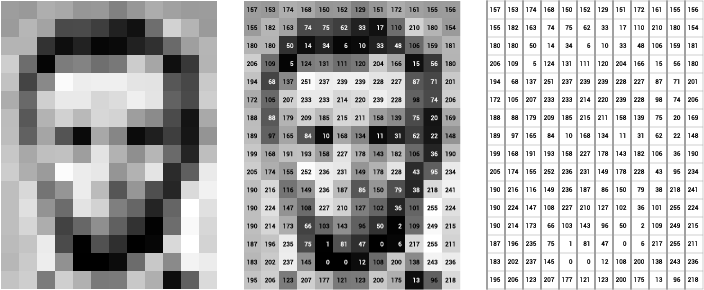

CNN TO THE RESCUE

A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

STEPS INVLOVED IN CNN
- A convolution does this by multiplying two matrices and yielding a third, smaller matrix.
- The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.
- In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.
- We use different filters to pass over our inputs, and take all the feature maps, put them together as the final output of the convolutional layer.
- We then pass the output of this layer through a non-linear activation function. The most commonly used one is ReLU.
- The next step of our process involves further reducing the dimensionality of the data which will lower the computation power required for training this model. This is achieved by using a Pooling Layer. The most commonly used one is max pooling which takes the maximum value in the window created by a filter. This significantly reduces the training time and preserves significant information.

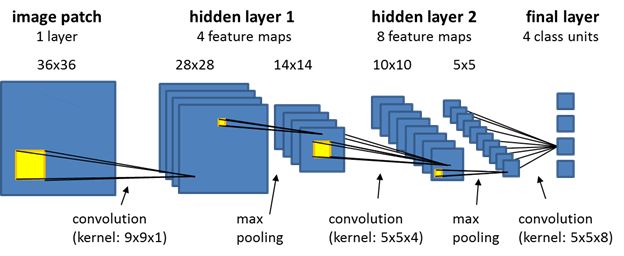

2. Data Augmentation 



The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. 

As this one of the first data augmentation, I used the code mentioned in the keras documentaion (https://keras.io/api/preprocessing/image/) and re-used it.

In [ ]:
train_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True) # same as in keras documentataion 
train_generator=train_data_generator.flow_from_directory(directory=train_dir, 
                                         batch_size=100, #chose a size at random
                                         target_size =(255,255), # assumed a target size
                                         shuffle=True,
                                         class_mode = 'binary')

val_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True)
val_generator=val_data_generator.flow_from_directory(directory=valid_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')

test_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True)
test_generator=test_data_generator.flow_from_directory(directory=test_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


3. Defining the CNN model

Define the model,cost function, optimizer, learning rate.

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c


Explaining this model


1.   Initially there are one convolutional layer followed by a max pooling layer to pick important features from convolution matrix 
2.   Flatten Layer flattens n-dimension matrix into 1-D so that it could be passed into Dense Layers
3.   Two Dense Layers which are fully conncectes : first layers has 4096 neurons and another has 1 neuron to give results which would be binary

As it was my first time building a CNN model by myself.

In [ ]:
model = Sequential()
#Sequential model means that all the layers of the model will be arranged in sequence.

model.add(Conv2D(input_shape=(255,255,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#64 channel, input size same as above with 3 channels ,filter size 3 x 3, padding is same, and activation is relu

model.add(BatchNormalization())
#64 filters, filter size 3 x 3, padding is same, and activation is relu

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# 1 x maxpool layer of 2x2 pool size and stride 2x2

# NEXT - 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#→ 2 x convolution layer of 128 channel of 3x3 kernal and same padding
#→ 1 x maxpool layer of 2x2 pool size and stride 2x2

# NEXT -3

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#→ 3 x convolution layer of 256 channel of 3x3 kernal and same padding
#→ 1 x maxpool layer of 2x2 pool size and stride 2x2

#NEXT - 4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding
#→ 1 x maxpool layer of 2x2 pool size and stride 2x2

# NEXT - 5
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding
#→ 1 x maxpool layer of 2x2 pool size and stride 2x2#
#I also add relu(Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))

'''
I will use RELU activation for both the dense layer of 4096 units so that 
I stop forwarding negative values through the network. 
I use a 2 unit dense layer in the end with softmax activation 
as I have 2 classes to predict from in the end which are pneumonia and non=pneumonia. 
The sigmoid layer will output the value between 0 and 1 based on 
the confidence of the model that which class the images belongs to.
'''

# compiling the model
from keras.optimizers import Adam
opt = Adam(lr=0.0001) #start with a small learning rate
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
'''
Here I will be using Adam optimiser to reach to the global minima while training out model. 
If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima 
and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at 0.001. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.
'''

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 128)     73856     
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0

In [ ]:
model_name = "best_model.h5"
#CALLBACK - 1 - early_stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 5) 
'''EarlyStopping helps us to stop the training of the model early if there is no increase 
in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation 
accuracy by passing val_acc to EarlyStopping. I have here set patience to 5 which means that the model 
will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.'''
# if for 5 epochs the val_acc does not improve the training is going to be intereppupted
#patience is how long the model is going to train without interuppting

#CALLBACK - 2 - monitor
monitor = tf.keras.callbacks.ModelCheckpoint (model_name, monitor = 'val_accuracy',save_best_only = True , save_weights_only = True )
# you save the best model and the weights
#the callback is going the keep on checking the validation error and if the validation error decreases then we will save the model as the best model
# mode is whether u wabnt to save the minimum or maximum value of the cost function, we are not defining mode as it is automatically defined defined by tf
'''
ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. 
In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. 
The model will only be saved to disk if the validation accuracy of the model in current 
epoch is greater than what it was in the last epoch.
'''

#CALLBACK - 3 - lr_schedule
def scheduler(epoch, lr):
  if epoch%10==0:  #every 10 epoch reduce the learning rate by a factor of 2 
    lr = lr/2
  return lr
  
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)# definding the callback


METHOD 1

In [ ]:
hist = model.fit_generator(steps_per_epoch=7,generator=train_generator, validation_data= val_generator, epochs=400,verbose = 1,callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/400
7/7 [==============================] - 1901s 303s/step - loss: 1.3468 - accuracy: 0.5426 - val_loss: 0.6909 - val_accuracy: 0.5590
Epoch 2/400
7/7 [==============================] - 944s 148s/step - loss: 0.4949 - accuracy: 0.7916 - val_loss: 0.6107 - val_accuracy: 0.7429
Epoch 3/400
7/7 [==============================] - 942s 148s/step - loss: 0.4773 - accuracy: 0.7904 - val_loss: 0.5822 - val_accuracy: 0.7429
Epoch 4/400
7/7 [==============================] - 941s 148s/step - loss: 0.4125 - accuracy: 0.8246 - val_loss: 0.5733 - val_accuracy: 0.7429
Epoch 5/400
7/7 [==============================] - 936s 147s/step - loss: 0.3487 - accuracy: 0.8367 - val_loss: 0.5904 - val_accuracy: 0.7429
Epoch 6/400
7/7 [==============================] - 937s 147s/step - loss: 0.3474 - accuracy: 0.8613 - val_loss: 0.6262 - val_accuracy: 0.7429
Epoch 7/400
7/7 [==============================] - 935s 147s/step - loss: 0.3137 - accuracy: 0.8595 - val_loss: 0.6747 - val_accuracy: 0.7429


METHOD 2

In [ ]:
hist_1 = model.fit(train_generator, validation_data= val_generator,batch_size = 64, epochs=  300, verbose = 1, callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)
#NEW FOR CNN - X-train representation is number of samples ,size of the image , number of channels , here we have only one channel so we add np.newaxis
#larger batches take longer to train and smaller batch sizes can train faster
#graident approxinmation for a small batch size may not be that good
# batch_size is the number of samples taht we use to estiamet teh gradient before taking one step
#shuffle ie.e batches that u snet to the GPU are shuffled

Epoch 1/300
7/7 [==============================] - 945s 148s/step - loss: 0.3250 - accuracy: 0.8638 - val_loss: 0.7181 - val_accuracy: 0.7429
Epoch 2/300
7/7 [==============================] - 937s 147s/step - loss: 0.3224 - accuracy: 0.8510 - val_loss: 0.7651 - val_accuracy: 0.7429
Epoch 3/300
7/7 [==============================] - 940s 148s/step - loss: 0.2954 - accuracy: 0.8814 - val_loss: 0.8100 - val_accuracy: 0.7429
Epoch 4/300
7/7 [==============================] - 938s 147s/step - loss: 0.2992 - accuracy: 0.8654 - val_loss: 0.8512 - val_accuracy: 0.7429
Epoch 5/300
7/7 [==============================] - 940s 148s/step - loss: 0.3029 - accuracy: 0.8686 - val_loss: 0.9142 - val_accuracy: 0.7429
Epoch 6/300
7/7 [==============================] - 940s 154s/step - loss: 0.3058 - accuracy: 0.8670 - val_loss: 0.9637 - val_accuracy: 0.7429


PLOTS

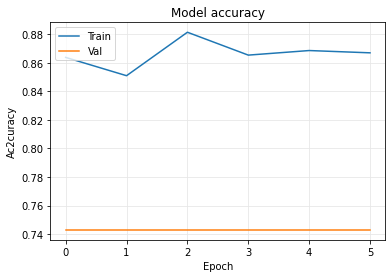

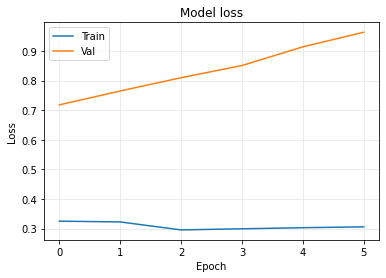

In [ ]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Ac2curacy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid(color='#e6e6e6')
plt.show()

plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(color='#e6e6e6')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

The model is severley overfitting. It turns out that the above VGG16 model that we created will not perform well for this problem s we need to change the model

TESTING THE MODEL

METHOD 1

In [ ]:
model.load_weights(model_name) # here the weight we are produced during model training
metrics = model.evaluate(test_generator) # it will return the loss and metrics when we are testing the model # here we have categorical cross entropy here is loss and accuracy is the metrics
#print(metrics) # in step 4 we stated that we wan to measure and monitor two metrics
print("Binary cross-entropy:" , metrics[0])
print("Accuracy:" , metrics[1])

1/1 [==============================] - 2s 2s/step - loss: 0.7182 - accuracy: 0.5000
Binary cross-entropy: 0.7181577682495117
Accuracy: 0.5


METHOD 2

In [ ]:
model.evaluate(test_generator)

1/1 [==============================] - 2s 2s/step - loss: 0.7110 - accuracy: 0.5000


[0.710969090461731, 0.5]

The accuracy of the model is 50% on testing set

ANOTHER CNNN MODEL

This model contains dropouts so it will perform well.

In [ ]:
cnn_model_drop=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(255,255,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), # First Convolution and Pooling Layers
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), # Second Convolution and Pooling Layers
    tf.keras.layers.Dropout(0.2), # First dropout
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2), # Third Convolution and Pooling Layers
    tf.keras.layers.Dropout(0.2), # Second dropout
    
    tf.keras.layers.Flatten(), # Flatten the Layers and Add Fully Connected Layers
    tf.keras.layers.Dropout(0.2), # Third dropout
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

# Compile the model using the adam optimizer, because it's essentially RMSProp with momentum. 
cnn_model_drop.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])


4. Defining 3 callbacks (callbacks means that if the model is not improving it will stop)

In [ ]:
model_name = "best_model.h5"
#CALLBACK - 1 - early_stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 5) 
'''EarlyStopping helps us to stop the training of the model early if there is no increase 
in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation 
accuracy by passing val_acc to EarlyStopping. I have here set patience to 5 which means that the model 
will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.'''
# if for 5 epochs the val_acc does not improve the training is going to be intereppupted
#patience is how long the model is going to train without interuppting

#CALLBACK - 2 - monitor
monitor = tf.keras.callbacks.ModelCheckpoint (model_name, monitor = 'val_accuracy',save_best_only = True , save_weights_only = True )
# you save the best model and the weights
#the callback is going the keep on checking the validation error and if the validation error decreases then we will save the model as the best model
# mode is whether u wabnt to save the minimum or maximum value of the cost function, we are not defining mode as it is automatically defined defined by tf
'''
ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. 
In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. 
The model will only be saved to disk if the validation accuracy of the model in current 
epoch is greater than what it was in the last epoch.
'''

#CALLBACK - 3 - lr_schedule
def scheduler(epoch, lr):
  if epoch%10==0:  #every 10 epoch reduce the learning rate by a factor of 2 
    lr = lr/2
  return lr
  
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)# definding the callback


5. RUNNING THE MODEL

METHOD 1

In [ ]:
hist = cnn_model_drop.fit_generator(steps_per_epoch=7,generator=train_generator, validation_data= val_generator, epochs=400,verbose = 1,callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/400
7/7 [==============================] - 1127s 186s/step - loss: 0.7285 - accuracy: 0.5189 - val_loss: 0.6866 - val_accuracy: 0.8075
Epoch 2/400
7/7 [==============================] - 278s 44s/step - loss: 0.6782 - accuracy: 0.6152 - val_loss: 0.6206 - val_accuracy: 0.7429
Epoch 3/400
7/7 [==============================] - 277s 46s/step - loss: 0.6649 - accuracy: 0.6135 - val_loss: 0.6328 - val_accuracy: 0.7429
Epoch 4/400
7/7 [==============================] - 276s 44s/step - loss: 0.6370 - accuracy: 0.6216 - val_loss: 0.5520 - val_accuracy: 0.7429
Epoch 5/400
7/7 [==============================] - 276s 44s/step - loss: 0.5988 - accuracy: 0.6260 - val_loss: 0.4910 - val_accuracy: 0.7590
Epoch 6/400
7/7 [==============================] - 278s 45s/step - loss: 0.5327 - accuracy: 0.7367 - val_loss: 0.4153 - val_accuracy: 0.7962


The accuracy of the new model is 79%

METHOD 2

In [ ]:
hist_2 = model.fit(train_generator, validation_data= val_generator,batch_size = 64, epochs=  300, verbose = 1, callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)
#NEW FOR CNN - X-train representation is number of samples ,size of the image , number of channels , here we have only one channel so we add np.newaxis
#larger batches take longer to train and smaller batch sizes can train faster
#graident approxinmation for a small batch size may not be that good
# batch_size is the number of samples taht we use to estiamet teh gradient before taking one step
#shuffle ie.e batches that u snet to the GPU are shuffled

Epoch 1/300
7/7 [==============================] - 2009s 319s/step - loss: 1.4468 - accuracy: 0.5647 - val_loss: 0.6366 - val_accuracy: 0.7429
Epoch 2/300
7/7 [==============================] - 1332s 210s/step - loss: 0.8708 - accuracy: 0.6924 - val_loss: 0.5696 - val_accuracy: 0.7429
Epoch 3/300
7/7 [==============================] - 1330s 210s/step - loss: 0.4363 - accuracy: 0.8100 - val_loss: 0.6261 - val_accuracy: 0.7429
Epoch 4/300
7/7 [==============================] - 1332s 210s/step - loss: 0.4194 - accuracy: 0.8126 - val_loss: 0.7905 - val_accuracy: 0.7429
Epoch 5/300
7/7 [==============================] - 1344s 211s/step - loss: 0.3809 - accuracy: 0.8369 - val_loss: 0.9535 - val_accuracy: 0.7429
Epoch 6/300
7/7 [==============================] - 1345s 212s/step - loss: 0.3897 - accuracy: 0.8175 - val_loss: 1.1732 - val_accuracy: 0.7429


The accuracy is a little lower here but still really good

PLOTTING THE VALIDATION AND TRAINING SET

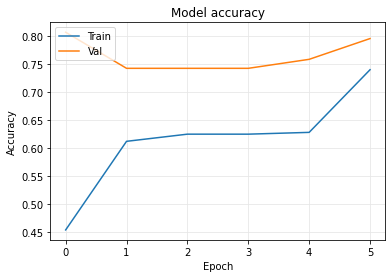

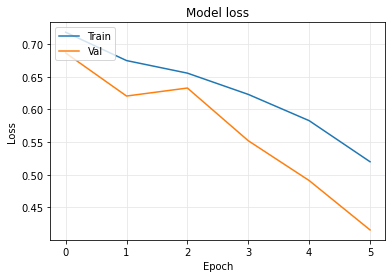

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid(color='#e6e6e6')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(color='#e6e6e6')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

The model is not overfitting and validation loss is slightly higher than training as expected. Clearly this new model that contains dropout is performing very well.

7.TESTING THE MODEL ON THE TEST SET AND EXTRACTING RELEVANT METRICS

Method 1

In [ ]:
cnn_model_drop.load_weights(model_name) # here the weight we are produced during model training
metrics = cnn_model_drop.evaluate(test_generator) # it will return the loss and metrics when we are testing the model # here we have categorical cross entropy here is loss and accuracy is the metrics
#print(metrics) # in step 4 we stated that we wan to measure and monitor two metrics
print("Binary cross-entropy:" , metrics[0])
print("Accuracy:" , metrics[1])

1/1 [==============================] - 1s 768ms/step - loss: 0.6904 - accuracy: 0.5625
Binary cross-entropy: 0.6904209852218628
Accuracy: 0.5625


Method 2

In [ ]:
cnn_model_drop.evaluate(test_generator)

1/1 [==============================] - 1s 796ms/step - loss: 0.6920 - accuracy: 0.6250


[0.6920373439788818, 0.625]

Accuracy is 62.5 % and loss is 0.69.

CONFUSION MATRIX

In [ ]:
predictions = cnn_model_drop.predict_classes(test_generator)

#predictions = predictions.reshape(1, -1)[0]
#predictions[:10]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
true_classes = test_generator.classes

In [ ]:
print(classification_report(true_classes, predictions, target_names= ['Covid-19(class 0)', 'Normal (class 1)'] ))

                   precision    recall  f1-score   support

Covid-19(class 0)       1.00      0.12      0.22         8
 Normal (class 1)       0.53      1.00      0.70         8

         accuracy                           0.56        16
        macro avg       0.77      0.56      0.46        16
     weighted avg       0.77      0.56      0.46        16



In [ ]:
cm = confusion_matrix(true_classes, predictions)
cm

array([[1, 7],
       [0, 8]])

In [ ]:
y_pred = cnn_model_drop.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = y_pred > 0.5

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[0.50690687]
 [0.5085432 ]
 [0.5035188 ]
 [0.51263803]
 [0.5122077 ]
 [0.5028666 ]
 [0.502067  ]
 [0.511577  ]
 [0.4975511 ]
 [0.5011088 ]
 [0.5026162 ]
 [0.50291514]
 [0.50088304]
 [0.5012021 ]
 [0.5066745 ]
 [0.5007453 ]]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         8
   PNEUMONIA       0.47      0.88      0.61         8

    accuracy                           0.44        16
   macro avg       0.23      0.44      0.30        16
weighted avg       0.23      0.44      0.30        16



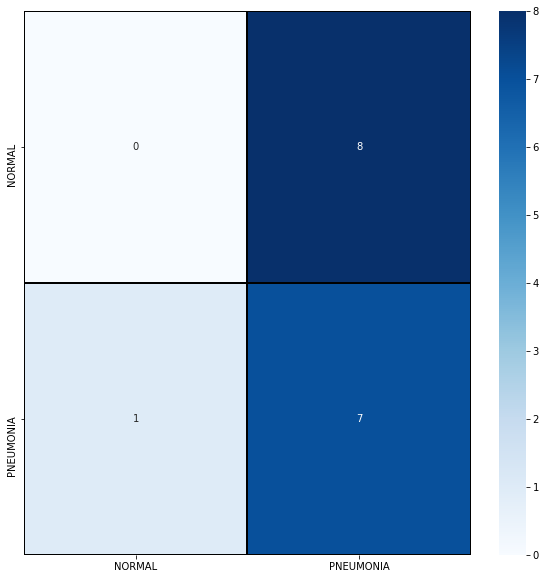

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

# classification report
target_names = train_generator.class_indices

print(classification_report(y_true, y_pred, target_names=target_names))

# confusion matrix
mat = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(mat, index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='',xticklabels = target_names, yticklabels = target_names)

In [ ]:
# Define 1:  train & validation loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

## Define 2: train & validation AUC
train_auc_name = list(hist.history.keys())[3]
val_auc_name = list(hist.history.keys())[1]
train_auc = hist.history[train_auc_name]
val_auc = hist.history[val_auc_name]

## Define 3: y_pred & y_true : y_test
prediction_probability = cnn_model_drop.predict(test_generator) 
prediction_class= cnn_model_drop.predict_classes(test_generator)
y_pred = (prediction_class > 0.5).T[0]
y_pred_prob = prediction_probability.T[0]



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars


[Classification Metrics Summary]
Accuracy = 50.00% | Precision = nan% | Recall = 0.00% | Specifity = 100.00% | F1 Score = nan%


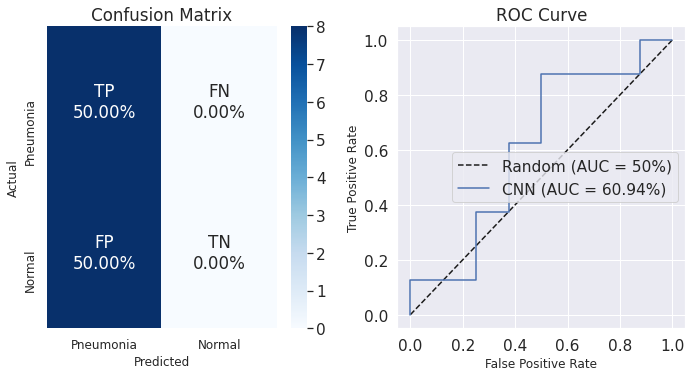

In [ ]:

fig = plt.figure(figsize=(10, 10))

y_test = test_generator.classes
# PLOT 3: CONFUSION MATRIX
plt.subplot(2,2,1)

    # Set up the labels for in the confusion matrix
cm = confusion_matrix(y_test, y_pred)
names = ['TP', 'FN', 'FP', 'TN']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Pneumonia','Normal']

    # Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size= 12)
plt.ylabel("Actual", size= 12) 

# PLOT 4: ROC CURVE
plt.subplot(2,2,2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.legend(loc='best')

# END PLOTS
plt.tight_layout()

# Summary Statistics

    #Accuracy : 1 - (Average Classification Error) = (TP + TN) / (TP + FN + TN + FP)  --> % positive out of all predicted positives
    #Precision : how many selected items are relevant = TP / (TP + FP)                --> % positive out of all predicted positives
    #Recall : how many relevant items are selected = TP / (TP + FN)                   --> % positive out of all supposed to be positives
    #Specifity :                                                                      --> % negative out of all supposed to be negatives
    #F1-score : harmonic mean between Precision and Recall = (2*precision * recall) / (precision + recall)

#cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TN, FP, FN, TP = cm.ravel()         
accuracy = (TP + TN) / np.sum(cm)   
precision = TP / (TP+FP)            
recall =  TP / (TP+FN)              
specifity = TN / (TN+FP)           
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Classification Metrics Summary]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specifity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specifity, f1)
print(stats_summary)

The above charts looks a little differnet. Its because the testing set has only 16 items in them. 